# Semantic Segmentation の体験
- [セマンティック・セグメンテーションの基礎](chrome-extension://mhjfbmdgcfjbbpaeojofohoefgiehjai/index.html)
- [自動運転にも応用される精緻な画像認識技術、「画像セグメンテーション」とは？事例を交えてわかりやすく解説｜株式会社インキュビット](http://incubit.co.jp/blog/3532)

In [5]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

warnings.filterwarnings('ignore')

%matplotlib inline

# データの準備

In [6]:
!wget -nv 'https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg' -O bird.png
!wget -nv 'https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg' -O horse.png
!wget -nv 'https://images.pexels.com/photos/1485799/pexels-photo-1485799.jpeg' -O person.png

2019-10-19 14:59:53 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]
2019-10-19 14:59:54 URL:https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg [6604923/6604923] -> "horse.png" [1]
2019-10-19 15:00:00 URL:https://images.pexels.com/photos/1485799/pexels-photo-1485799.jpeg [22870459/22870459] -> "person.png" [1]


# raw image

In [7]:
from pathlib import Path

image_path_list = list(Path('.').glob('*.png'))

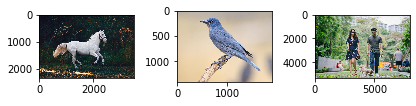

In [13]:
for idx, image_path in enumerate(image_path_list, start=1):
    plt.subplot(1, len(image_path_list), idx)
    image = Image.open(image_path)
    
    plt.tight_layout()
    plt.imshow(image)

plt.show()

# model

In [14]:
from torchvision import models

model = models.segmentation.fcn_resnet101(pretrained=True)

model.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [15]:
dummy_inputs = torch.ones(2, 3, 224, 224)

outputs = model(dummy_inputs)

In [16]:
type(outputs), outputs.keys()

(collections.OrderedDict, odict_keys(['out', 'aux']))

In [17]:
outputs['out'].size()

torch.Size([2, 21, 224, 224])

In [18]:
# aux loss
outputs['aux'].size()

torch.Size([2, 21, 224, 224])

# 各ピクセルのLabelを抜き出す

In [19]:
from torchvision import transforms

my_transform = transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225])])

# バッチサイズに対応させる
input_ = my_transform(image)
print(input_.size())

input_ = input_.unsqueeze(0)
print(input_.size())

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [20]:
output = model(input_)['out']
print(output.size())

# 戻す
output = output.squeeze()
print(output.size())

torch.Size([1, 21, 224, 224])
torch.Size([21, 224, 224])


In [21]:
_, y_pred = torch.max(output, dim=0)
label = y_pred.detach().cpu().numpy()

print(label.shape)
print(np.unique(label))

(224, 224)
[ 0 15]


In [22]:
label[128]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15, 15, 15, 15, 15, 15, 15,
       15, 15,  0,  0,  0, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

In [24]:
num_classes = 21

class_label_colors = np.array([
    (0, 0, 0),  # 0=background
    (128, 0, 0),  # 1=aeroplane
    (0, 128, 0),  # 2=bicycle
    (128, 128, 0),  # 3=bird
    (0, 0, 128),  # 4=boat
    (128, 0, 128),  # 5=bottle
    (0, 128, 128),  # 6=bus
    (128, 128, 128),  # 7=car
    (64, 0, 0),  # 8=cat
    (192, 0, 0),  # 9=chair
    (64, 128, 0),  # 10=cow
    (192, 128, 0),  # 11=dining table
    (64, 0, 128),  # 12=dog
    (192, 0, 128),  # 13=horse
    (64, 128, 128),  # 14=motorbike
    (192, 128, 128),  # 15=person
    (0, 64, 0),  # 16=potted plant
    (128, 64, 0),  # 17=sheep
    (0, 192, 0),  # 18=sofa
    (128, 192, 0),  # 19=train
    (0, 64, 128)  # 20=tv/monitor
])


def decode_segmap(image, num_classes: int = 21):
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(num_classes):
        idx = image == l
        r[idx] = class_label_colors[l, 0]
        g[idx] = class_label_colors[l, 1]
        b[idx] = class_label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

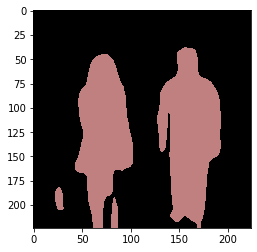

In [25]:
rgb = decode_segmap(label)

plt.imshow(rgb)
plt.show()

In [26]:
from torchvision import transforms


def show_segmatation(model, file_path):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    img = Image.open(file_path)

    # show original image
    plt.imshow(img)
    plt.show()

    transform = transforms.Compose([transforms.Resize(512),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
    input_ = transform(img).unsqueeze(0).to(device)
    output = model(input_)['out']
    _, y_pred = torch.max(output.squeeze(), dim=0)
    label = y_pred.detach().cpu().numpy()

    rgb = decode_segmap(label)

    plt.imshow(rgb)
    plt.show()

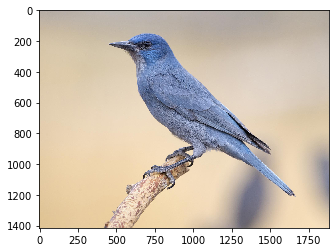

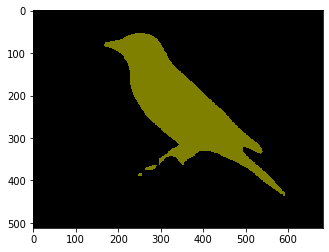

In [27]:
show_segmatation(model, './bird.png')

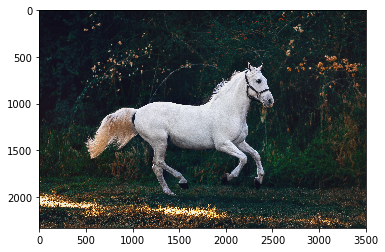

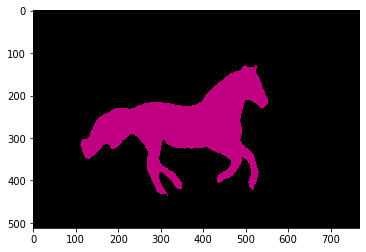

In [28]:
show_segmatation(model, './horse.png')

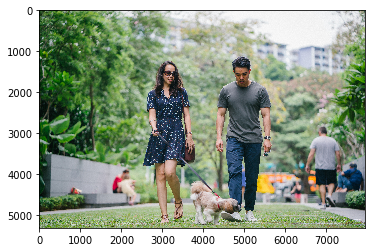

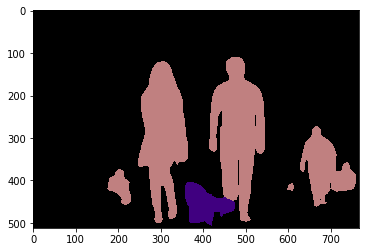

In [29]:
show_segmatation(model, './person.png')

おわり